# 1. Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from k_means import KMeans 


# 2. Wine Data
First, to test that this works, we'll implement the algorithm on the same wine dataset to see how well it works.

In [2]:

# Load wine data
data = load_wine()
X = data.data

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


Cluster Centers:
 [[-0.92607185 -0.39404154 -0.49451676  0.17060184 -0.49171185 -0.07598265
   0.02081257 -0.03353357  0.0582655  -0.90191402  0.46180361  0.27076419
  -0.75384618]
 [ 0.83523208 -0.30380968  0.36470604 -0.61019129  0.5775868   0.88523736
   0.97781956 -0.56208965  0.58028658  0.17106348  0.47398365  0.77924711
   1.12518529]
 [ 0.16490746  0.87154706  0.18689833  0.52436746 -0.07547277 -0.97933029
  -1.21524764  0.72606354 -0.77970639  0.94153874 -1.16478865 -1.29241163
  -0.40708796]]
Silhouette Score: 0.2848589191898987


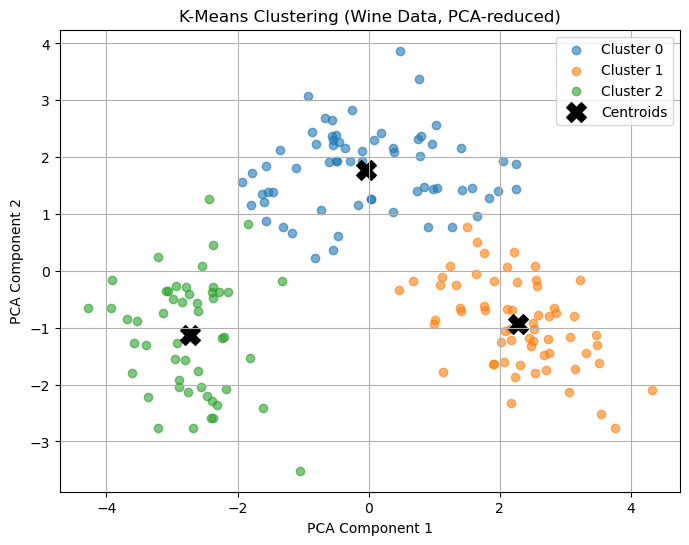

In [3]:

# Apply custom KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Print cluster centers and silhouette score
print("Cluster Centers:\n", kmeans.centroids)
print("Silhouette Score:", kmeans.score(X_scaled))

# Plot clusters
plt.figure(figsize=(8, 6))
for i in range(3):
    cluster_points = X_pca[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}', alpha=0.6)

# Plot centroids (projected)
centroids_pca = pca.transform(kmeans.centroids)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], color='black', marker='X', s=200, label='Centroids')

plt.title("K-Means Clustering (Wine Data, PCA-reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()


As we can see, it produced three clusters, which is actually pretty good considering that it did not initially know that the wine dataset also had three different categories. We visualized the clusters in a PCA reduced table, which simplified the visualization a little bit considering that we actually have a dataset of much higher dimension. However, this is pretty good.

# 3. Testing On NFL Quarterbacks

Now, we'll test this on a much more complicated dataset, using NFL career passing stats. This requires a significant amount of pre-processing sincet the data is messy.

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from k_means import KMeans  # Assumes you have a custom KMeans implementation

# Load dataset
df = pd.read_csv("Career_Stats_Passing.csv")
# Remove rows with any missing values
df.dropna(inplace=True)

# Remove rows with any zeros in any column
df = df[(df != 0).all(axis=1)]

df["Passes Attempted"] = (
    df["Passes Attempted"]
    .str.replace(",", "")  # remove commas
    .astype(float)         # convert to float
)

# Optional: reset index after filtering
df.reset_index(drop=True, inplace=True)


# View the cleaned dataset

print(df.head())
df.dtypes

                Player Id              Name Position  Year  \
0       tomsavage/2543640       Savage, Tom       QB  2016   
1       tomsavage/2543640       Savage, Tom       QB  2014   
2      connorcook/2555332      Cook, Connor       QB  2016   
3  jamisoncrowder/2552415  Crowder, Jamison       WR  2015   
4      phildawson/2500351      Dawson, Phil        K  2009   

                  Team  Games Played  Passes Attempted Passes Completed  \
0       Houston Texans             3              73.0               46   
1       Houston Texans             2              19.0               10   
2      Oakland Raiders             1              21.0               14   
3  Washington Redskins            16               1.0                0   
4     Cleveland Browns            11               1.0                1   

  Completion Percentage  Pass Attempts Per Game  ... TD Passes  \
0                  63.0                    24.3  ...         0   
1                  52.6                     

Player Id                          object
Name                               object
Position                           object
Year                                int64
Team                               object
Games Played                        int64
Passes Attempted                  float64
Passes Completed                   object
Completion Percentage              object
Pass Attempts Per Game            float64
Passing Yards                      object
Passing Yards Per Attempt          object
Passing Yards Per Game             object
TD Passes                          object
Percentage of TDs per Attempts     object
Ints                               object
Int Rate                           object
Longest Pass                       object
Passes Longer than 20 Yards        object
Passes Longer than 40 Yards        object
Sacks                              object
Sacked Yards Lost                  object
Passer Rating                     float64
dtype: object

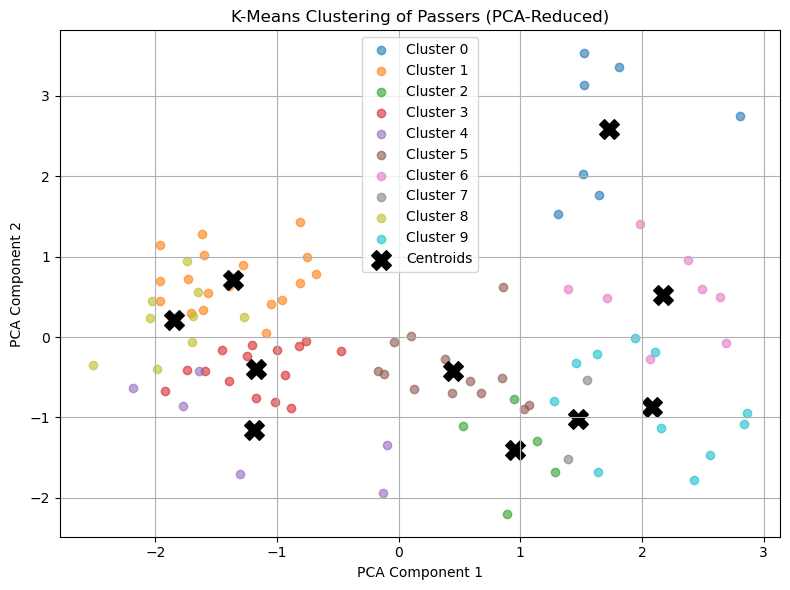

Top Passers in Each Cluster:
                          Name  Passes Attempted  Cluster
Cluster                                                  
0       363       Nassib, Ryan               5.0        0
        248     Lechler, Shane               3.0        0
        241      Sanu, Mohamed               3.0        0
1       29         Brees, Drew             673.0        1
        393        Flacco, Joe             672.0        1
        46      Rivers, Philip             661.0        1
2       27        McCown, Luke             139.0        2
        13         Yates, T.J.             134.0        2
        487      Johnson, Josh             125.0        2
3       370      Bradford, Sam             590.0        3
        452  Fitzpatrick, Ryan             569.0        3
        444      Sanchez, Mark             543.0        3
4       207        Cutler, Jay             616.0        4
        385    Anderson, Derek             527.0        4
        505       Cassel, Matt             

In [25]:
df = df.loc[df.groupby("Name")["Passes Attempted"].idxmax()]

# Drop players in the bottom 5% of Passes_Attempted
threshold = np.percentile(df["Passes Attempted"], 5)
df_filtered = df[df["Passes Attempted"] > threshold].copy()

# Keep player info for final display
player_info = df_filtered[["Player ID", "Passes Attempted"]] if "Player" in df.columns else None

# Drop non-numeric and identifier columns for clustering
exclude_cols = ["Name", "Player_ID"] if "Name" in df.columns and "Player_ID" in df.columns else []
X = df_filtered.drop(columns=exclude_cols).select_dtypes(include=[np.number])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Fit custom KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Add cluster labels back to original dataframe
df_filtered["Cluster"] = labels

# Show top 3 passers in each cluster
top_passers = df_filtered.groupby("Cluster").apply(lambda g: g.nlargest(3, "Passes Attempted"))[["Name", "Passes Attempted", "Cluster"]]

# Plot clusters
plt.figure(figsize=(8, 6))
for i in range(10):
    cluster_points = X_pca[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}', alpha=0.6)

# Project centroids for plotting
centroids_pca = pca.transform(kmeans.centroids)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], color='black', marker='X', s=200, label='Centroids')

plt.title("K-Means Clustering of Passers (PCA-Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print top passers per cluster
print("Top Passers in Each Cluster:")
print(top_passers)


On the surface, this seems to have done a pretty good job of broadly classifying quarterbacks, because similar quarterbacks have been grouped together, including non quarterbacks such as Ryan Nassib and Mohammed Sanu. These guys are not quarterbacks, and the algorithm has done a good job of separating them from other players who actually are quarterbacks.